In [1]:
import numpy as np 
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import time
import datetime
from datetime import datetime
import calendar

from sklearn import model_selection # model assesment and model selection strategies
from sklearn import metrics # model evaluation metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix


sns.set_style('white')

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# reduces the memory of a dataframe
def reduce_mem_usage(df, verbose = True):
    
    '''
    Reduces the space that a DataFrame occupies in memory.

    This function iterates over all columns in a df and downcasts them to lower type to save memory.
    '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'\
              .format(end_mem, 100 * (start_mem - end_mem) / start_mem))

# Cargamos el dataset Base:

In [3]:
df_sorted = pd.read_pickle('../Datos-Easymoney/EasyMoney_base.pkl',compression='zip')

In [4]:
df_sorted.isnull().sum().sum()

0

In [5]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 5962923
Data columns (total 59 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   pk_cid                  int32         
 1   pk_partition            datetime64[ns]
 2   short_term_deposit      int8          
 3   loans                   int8          
 4   mortgage                int8          
 5   funds                   int8          
 6   securities              int8          
 7   long_term_deposit       int8          
 8   em_account_pp           int8          
 9   credit_card             int8          
 10  payroll                 float16       
 11  pension_plan            float16       
 12  payroll_account         int8          
 13  emc_account             int8          
 14  debit_card              int8          
 15  em_account_p            int8          
 16  em_acount               int8          
 17  entry_date              datetime64[ns]
 18  en

Vamos a generar 3 variables agurpando las latas por los tipos de productos que tenemos: 

# Variable dif_cuentaSimple:

Si hay algun alta de alguno de los productos de cuenta simple, esta variable tendra un 1.Si no tendra un 0

In [6]:
df_sorted.loc[ (df_sorted['dif_debit_card']==1) | 
               (df_sorted['dif_em_account_p']==1) |
               (df_sorted['dif_em_account_pp']==1) |
               (df_sorted['dif_em_acount']==1) |
               (df_sorted['dif_emc_account']==1) |
               (df_sorted['dif_payroll']==1) |
               (df_sorted['dif_payroll_account']==1), 'dif_cuentaSimple']=1

# Variable dif_ahorroInversion:

Si hay algun alta de alguno de los productos de ahorro/inversion, esta variable tendra un 1.Si no tendra un 0

In [8]:
df_sorted.loc[ (df_sorted['dif_funds']==1) | 
               (df_sorted['dif_long_term_deposit']==1) |
               (df_sorted['dif_mortgage']==1) |
               (df_sorted['dif_pension_plan']==1) |
               (df_sorted['dif_securities']==1) |
               (df_sorted['short_term_deposit']==1) , 'dif_ahorroInversion']=1

# Variable dif_financiacion:

Si hay algun alta de alguno de los productos de financiacion, esta variable tendra un 1.Si no tendra un 0

In [10]:
df_sorted.loc[ (df_sorted['loans']==1) | 
               (df_sorted['dif_credit_card']==1)  , 'dif_financiacion']=1

# Fill nans

Rellenamos los nulos que se nos han generado en las tres nueva variables y los reemplazamos por 0.

In [11]:
df_sorted['dif_cuentaSimple'].fillna(0,inplace=True)
df_sorted['dif_ahorroInversion'].fillna(0,inplace=True)
df_sorted['dif_financiacion'].fillna(0,inplace=True)

Pintamos alguna de estas variables para ver si realmente estan funcionando bien:

In [13]:
#Para dif_cuentaSimple:
cuentas_easymoney = ['dif_debit_card','dif_em_account_p','dif_em_account_pp',
                     'dif_em_acount','dif_emc_account','dif_payroll','dif_payroll_account',
                    'dif_cuentaSimple']

In [14]:
df_sorted[df_sorted['pk_cid']==1035440  ][cuentas_easymoney].head(10).T

,451204,451205,451206,451207,451208,451209,451210,451211,451212,451213
dif_debit_card,0.00,0.00,0.00,0.00,-1.00,1.00,0.00,0.00,0.00,0.00
dif_em_account_p,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_em_account_pp,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_em_acount,0.00,-1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_emc_account,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_payroll,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_payroll_account,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_cuentaSimple,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00


In [15]:
df_sorted.isnull().sum().sum()

0

# Vamos a hacer el producto cartesiano para predecir
Solo clientes activos(Con producto)

In [16]:
lista_fechas=['2018-01-28',
'2018-02-28',
'2018-03-28',
'2018-04-28',
'2018-05-28',
'2018-06-28',
'2018-07-28',
'2018-08-28',
'2018-09-28',
'2018-10-28',
'2018-11-28',
'2018-12-28',
'2019-01-28',
'2019-02-28',
'2019-03-28',
'2019-04-28',
'2019-05-28',             
'2019-06-28']

Solo vamos a predecir para los clientes activos el ultimo mes:

In [17]:
lista_clientes=df_sorted[(df_sorted['isActive']==1) & 
                        (df_sorted['pk_partition']=='2019-05-28')]["pk_cid"].unique().tolist()

In [19]:
# Tenemos 331588 clientes activos el ultimo mes:
len(lista_clientes)

331588

In [20]:
cartesian_product = pd.MultiIndex.from_product([lista_fechas, lista_clientes ], names = ["pk_partition", "pk_cid"])
len(cartesian_product)

5968584

In [21]:
cartesian_product

MultiIndex([('2018-01-28',   16203),
            ('2018-01-28',   16502),
            ('2018-01-28',   17457),
            ('2018-01-28',   17799),
            ('2018-01-28',   17970),
            ('2018-01-28',   17980),
            ('2018-01-28',   18146),
            ('2018-01-28',   18704),
            ('2018-01-28',   19021),
            ('2018-01-28',   19268),
            ...
            ('2019-06-28', 1553390),
            ('2019-06-28', 1553393),
            ('2019-06-28', 1553415),
            ('2019-06-28', 1553429),
            ('2019-06-28', 1553436),
            ('2019-06-28', 1553456),
            ('2019-06-28', 1553541),
            ('2019-06-28', 1553559),
            ('2019-06-28', 1553565),
            ('2019-06-28', 1553571)],
           names=['pk_partition', 'pk_cid'], length=5968584)

In [22]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()
full_df.tail()

,pk_partition,pk_cid
5968579,2019-06-28,1553456
5968580,2019-06-28,1553541
5968581,2019-06-28,1553559
5968582,2019-06-28,1553565
5968583,2019-06-28,1553571


Ponemos el campo pk_partition de este dataframe como de tipo fecha para poder hacer luego el Merge:

In [23]:
full_df['pk_partition']=pd.to_datetime(full_df['pk_partition'], format='%Y-%m-%d')

In [24]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    331588
2018-02-28    331588
2018-03-28    331588
2018-04-28    331588
2018-05-28    331588
2018-06-28    331588
2018-07-28    331588
2018-08-28    331588
2018-09-28    331588
2018-10-28    331588
2018-11-28    331588
2018-12-28    331588
2019-01-28    331588
2019-02-28    331588
2019-03-28    331588
2019-04-28    331588
2019-05-28    331588
2019-06-28    331588
Name: pk_cid, dtype: int64

Hacemos el Merge de la estructura generada mediante el producto cartesiano y el dataset con los datasetos de EasyMoney

In [25]:
full_df = pd.merge(full_df,df_sorted , on = ["pk_partition", "pk_cid"], how = 'left')

In [26]:
# Vemos el dataset resultante:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    331588
2018-02-28    331588
2018-03-28    331588
2018-04-28    331588
2018-05-28    331588
2018-06-28    331588
2018-07-28    331588
2018-08-28    331588
2018-09-28    331588
2018-10-28    331588
2018-11-28    331588
2018-12-28    331588
2019-01-28    331588
2019-02-28    331588
2019-03-28    331588
2019-04-28    331588
2019-05-28    331588
2019-06-28    331588
Name: pk_cid, dtype: int64

In [27]:
# Liberamos espacio en memoria para minimizar la posibilidad de tener erroes por falta de memoria.
del df_sorted
gc.collect()

51047

In [26]:
# Hacemos un pickel en este punto
#full_df.to_pickle('fulldf_base.pkl',compression='zip')

Debido al producto cartesiano se nos han generado nulos para los clientes modernos en las particiones mas antiguas.
Podemos comprobar que en el ultimo mes con datos (2019-05-28) , no tenemos nulos ya que hay hemos cogido todos los clientes.

In [29]:
# Nulos debidos al producto cartesiano
full_df[full_df['entry_date'].isnull()].groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    105082
2018-02-28    102163
2018-03-28     99439
2018-04-28     97067
2018-05-28     94559
2018-06-28     92249
2018-07-28     75495
2018-08-28     64161
2018-09-28     46426
2018-10-28     29032
2018-11-28     19458
2018-12-28     15461
2019-01-28     10911
2019-02-28      7185
2019-03-28      4038
2019-04-28      1612
2019-06-28    331588
Name: pk_cid, dtype: int64

In [30]:
# Vemos los nulos en el dataset:
full_df

,pk_partition,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,...,totalBeneficio,hayAlta,diasDesdeUltimaAlta,diasDesdeUltimaAltaInt,hayBaja,diasDesdeUltimaBaja,diasDesdeUltimaBajaInt,dif_cuentaSimple,dif_ahorroInversion,dif_financiacion
0,2018-01-28,16203,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan
1,2018-01-28,16502,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan
2,2018-01-28,17457,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,90.00,0.00,1 days 00:00:00,1.00,0.00,1 days 00:00:00,1.00,0.00,0.00,0.00
3,2018-01-28,17799,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.00,1.00,0 days 00:00:00,0.00,0.00,1 days 00:00:00,1.00,1.00,0.00,0.00
4,2018-01-28,17970,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,50.00,0.00,1 days 00:00:00,1.00,0.00,1 days 00:00:00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5968579,2019-06-28,1553456,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan
5968580,2019-06-28,1553541,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan
5968581,2019-06-28,1553559,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan
5968582,2019-06-28,1553565,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan


Borramos todos los nulos generados por el producto cartesiano, excepto en el mes futuro a predecir 2019-06-28

In [31]:
# Borramos todos los nulos que se generan por el producto cartesiano:
full_df.drop (full_df[ (full_df['pk_partition']!='2019-06-28') &
                       (full_df['entry_date'].isnull()) ].index, axis=0, inplace=True)

Vemos que solo tenemos nulos en el mes futuro a predecir 2019-06-28:

In [32]:
full_df[full_df['entry_date'].isnull()].groupby('pk_partition')['pk_cid'].size()

pk_partition
2019-06-28    331588
Name: pk_cid, dtype: int64

Vemos como se nos distribuyen los clientes por los diversos meses:

In [33]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    226506
2018-02-28    229425
2018-03-28    232149
2018-04-28    234521
2018-05-28    237029
2018-06-28    239339
2018-07-28    256093
2018-08-28    267427
2018-09-28    285162
2018-10-28    302556
2018-11-28    312130
2018-12-28    316127
2019-01-28    320677
2019-02-28    324403
2019-03-28    327550
2019-04-28    329976
2019-05-28    331588
2019-06-28    331588
Name: pk_cid, dtype: int64

Rellenamos los datos que si sabemos y podemos utilizar en el mes futuro a predecir:

In [34]:
# Actualizamos el mes a predecir:2019-06-28 con los valores de los clientes 
lista_actualizar=['entry_date',
 #'entry_channel',
 'active_customer',
 #'segment',
 #'country_id',
 'region_code',
 #'gender',
 'age',
 #'deceased', 
 #'mesesAlta',
'salary']

In [35]:
# Rellenamos entry_date para el ultimo mes:
for x in lista_actualizar:
    print(x)
    full_df.loc[(full_df['pk_partition']=='2019-06-28'),
            x]=full_df[full_df['pk_partition']=='2019-06-28']['pk_cid'].map(full_df[['pk_cid',x]].groupby('pk_cid')[x].max())

entry_date
active_customer
region_code
age
salary


Comprobamos que solo tenemos nulos en el mes a predecir:

In [36]:
# Solo tenemos nulos en el mes a predecir
full_df.isnull().sum()

pk_partition                   0
pk_cid                         0
short_term_deposit        331588
loans                     331588
mortgage                  331588
                           ...  
diasDesdeUltimaBaja       331588
diasDesdeUltimaBajaInt    331588
dif_cuentaSimple          331588
dif_ahorroInversion       331588
dif_financiacion          331588
Length: 62, dtype: int64

Vemos que tenemos datos para clientes en los que no pasa nada, son todo ceros:

In [37]:
full_df[(full_df['isNewClient']==0) &
        (full_df['isActive']==0)].T

,25,49,84,173,220,374,412,442,604,746,...,5303901,5303902,5303903,5303904,5303905,5303906,5303907,5303908,5303909,5303910
pk_partition,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,...,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00
pk_cid,25612,35849,46823,83660,102549,151516,162194,173207,220336,271773,...,1548181,1548182,1548186,1548188,1548189,1548196,1548197,1548201,1548202,1548203
short_term_deposit,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
loans,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
mortgage,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
diasDesdeUltimaBaja,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,...,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
diasDesdeUltimaBajaInt,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
dif_cuentaSimple,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_ahorroInversion,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Borramos los meses que no pasa nada para que el modelo aprenda a coger emjor los cambios.
El rendimiento del modelo mejora con esto:

In [38]:
# Borramos los meses que no pasa nada para que el modelo aprenda a coger emjor los cambios.
# El rendimiento del modelo mejora con esto:
full_df.drop(full_df[(full_df['isNewClient']==0) &
                     (full_df['isActive']==0)].index ,axis=0, inplace=True)

Vemos la distribucion final de los clientes por los meses:

In [39]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    225280
2018-02-28    228190
2018-03-28    231046
2018-04-28    233515
2018-05-28    236109
2018-06-28    238471
2018-07-28    250654
2018-08-28    263897
2018-09-28    280575
2018-10-28    298855
2018-11-28    308341
2018-12-28    312624
2019-01-28    317763
2019-02-28    321798
2019-03-28    325130
2019-04-28    328546
2019-05-28    331588
2019-06-28    331588
Name: pk_cid, dtype: int64

In [40]:
full_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5063970 entries, 2 to 5968583
Data columns (total 62 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   pk_partition            datetime64[ns]
 1   pk_cid                  int64         
 2   short_term_deposit      float64       
 3   loans                   float64       
 4   mortgage                float64       
 5   funds                   float64       
 6   securities              float64       
 7   long_term_deposit       float64       
 8   em_account_pp           float64       
 9   credit_card             float64       
 10  payroll                 float16       
 11  pension_plan            float16       
 12  payroll_account         float64       
 13  emc_account             float64       
 14  debit_card              float64       
 15  em_account_p            float64       
 16  em_acount               float64       
 17  entry_date              datetime64[ns]
 18  en

In [41]:
# Reducimos el tamaño del dataset para agilizar su manejo en memoria:
reduce_mem_usage(full_df, verbose = True)

Mem. usage decreased to 975.53 Mb (44.2% reduction)


In [40]:
#full_df.to_pickle('fulldf_base_nandropped_VII.pkl',compression='zip')

In [42]:
# Lista de columnas que nos informan de las altas o bajas:
delta_productos_easymoney=['dif_loans',
 'dif_mortgage',
 'dif_funds',
 'dif_securities',
 'dif_long_term_deposit',
 'dif_short_term_deposit',                          
 'dif_em_account_pp',
 'dif_credit_card',
 'dif_payroll',
 'dif_pension_plan',
 'dif_payroll_account',
 'dif_emc_account',
 'dif_debit_card',
 'dif_em_acount',
 'dif_em_account_p',
 'dif_cuentaSimple',
 'dif_ahorroInversion',                       
 'dif_financiacion']

In [43]:
# Lista de columnas que nos informan del numero de productos Easymoney del cliente:
productos_easymoney=['loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'short_term_deposit',                    
 'em_account_pp',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_acount',
 'em_account_p']

Ponemos a 0 las bajas para solo predecir altas:

In [44]:
for x in delta_productos_easymoney:
      full_df.loc[full_df[x]==-1, x ]=0  

In [45]:
full_df['dif_em_acount'].value_counts()

0.00    4613569
1.00     118813
Name: dif_em_acount, dtype: int64

In [46]:
full_df['dif_credit_card'].value_counts()

0.00    4721714
1.00      10668
Name: dif_credit_card, dtype: int64

In [46]:
#full_df.to_pickle('./fulldf_base_VII.pkl',compression='zip')

In [47]:
#full_df=pd.read_pickle('./fulldf_base_V1.pkl',compression='zip')

# Feature engeniering

Sacamos las variables LAGS remontandonos 1,2,3 y 4 meses atras para todas las variables delta_productos_easymoney:

In [47]:
for y in delta_productos_easymoney:
    print(y)
    for x in [1,2,3,4]:
        print(x)
        full_df[y+'_shift_'+str(x)]=full_df.groupby(['pk_cid'])[y].shift(x)

dif_loans
1
2
3
4
dif_mortgage
1
2
3
4
dif_funds
1
2
3
4
dif_securities
1
2
3
4
dif_long_term_deposit
1
2
3
4
dif_short_term_deposit
1
2
3
4
dif_em_account_pp
1
2
3
4
dif_credit_card
1
2
3
4
dif_payroll
1
2
3
4
dif_pension_plan
1
2
3
4
dif_payroll_account
1
2
3
4
dif_emc_account
1
2
3
4
dif_debit_card
1
2
3
4
dif_em_acount
1
2
3
4
dif_em_account_p
1
2
3
4
dif_cuentaSimple
1
2
3
4
dif_ahorroInversion
1
2
3
4
dif_financiacion
1
2
3
4


In [48]:
for y in productos_easymoney:
    print(y)
    for x in [1,2,3,4]:
        print(x)
        full_df[y+'_shift_'+str(x)]=full_df.groupby(['pk_cid'])[y].shift(x)

loans
1
2
3
4
mortgage
1
2
3
4
funds
1
2
3
4
securities
1
2
3
4
long_term_deposit
1
2
3
4
short_term_deposit
1
2
3
4
em_account_pp
1
2
3
4
credit_card
1
2
3
4
payroll
1
2
3
4
pension_plan
1
2
3
4
payroll_account
1
2
3
4
emc_account
1
2
3
4
debit_card
1
2
3
4
em_acount
1
2
3
4
em_account_p
1
2
3
4


In [50]:
for x in [1,2,3,4]:
    print(x)
    full_df['isActive_shift_'+str(x)]=full_df.groupby(['pk_cid'])['isActive'].shift(x)
    full_df['isNewClient_shift_'+str(x)]=full_df.groupby(['pk_cid'])['isNewClient'].shift(x)
    full_df['active_customer_shift_'+str(x)]=full_df.groupby(['pk_cid'])['active_customer'].shift(x)
    full_df['totalAssets_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalAssets'].shift(x)
    full_df['totalCuentas_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalCuentas'].shift(x)
    full_df['totalAhorro_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalAhorro'].shift(x)
    full_df['totalFinanciacion_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalFinanciacion'].shift(x)
    full_df['totalIngresos_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalIngresos'].shift(x)
    #full_df['totalBeneficio_shift'+str(x)]=full_df.groupby(['pk_cid'])['totalBeneficio'].shift(x) AUTOEXPLICATIVA
    full_df['diasDesdeUltimaAltaInt_shift_'+str(x)]=full_df.groupby(['pk_cid'])['diasDesdeUltimaAltaInt'].shift(x)
    full_df['hayAlta_shift_'+str(x)]=full_df.groupby(['pk_cid'])['hayAlta'].shift(x)
    full_df['diasDesdeUltimaBajaInt_shift_'+str(x)]=full_df.groupby(['pk_cid'])['diasDesdeUltimaAltaInt'].shift(x)
    full_df['hayBaja_shift_'+str(x)]=full_df.groupby(['pk_cid'])['hayAlta'].shift(x)

1
2
3
4


In [49]:
# Rellenamos los nulos producidos en las shift
full_df.fillna(-999,inplace=True)

Sacamos las variables de las fechas:

In [50]:
full_df["day"] = full_df["pk_partition"].dt.day
full_df["year"] = full_df["pk_partition"].dt.year
full_df["month"] = full_df["pk_partition"].dt.month

In [51]:
full_df["entry_date_day"] = full_df["entry_date"].dt.day
full_df["entry_date_year"] = full_df["entry_date"].dt.year
full_df["entry_date_month"] = full_df["entry_date"].dt.month

Sacamos algunas variables mas:

In [52]:
full_df['entry_channel'].value_counts(dropna=False).head(10)

KHE     2655442
KFC      625714
KHQ      435667
-999     331588
KAT      327988
KHK      157376
KHM      122421
KHN       82093
XXX       81657
KHD       63068
Name: entry_channel, dtype: int64

In [53]:
full_df.loc[full_df['entry_channel']==-999,'entry_channel']='XXX'

In [54]:
full_df['entry_channel']=pd.Categorical(full_df['entry_channel'], categories=full_df['entry_channel'].value_counts(dropna=False).head(10).index.to_list())

In [55]:
full_df['entry_channel'].value_counts(dropna=False)

KHE    2655442
KFC     625714
KHQ     435667
XXX     413245
KAT     327988
KHK     157376
KHM     122421
NaN     121686
KHN      82093
KHD      63068
KFA      59270
Name: entry_channel, dtype: int64

In [56]:
dummy_dataset = pd.get_dummies(full_df['entry_channel'],prefix='channel')

In [57]:
dummy_dataset

,channel_KHE,channel_KFC,channel_KHQ,channel_XXX,channel_KAT,channel_KHK,channel_KHM,channel_KHN,channel_KHD,channel_KFA
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
5968579,0,0,0,1,0,0,0,0,0,0
5968580,0,0,0,1,0,0,0,0,0,0
5968581,0,0,0,1,0,0,0,0,0,0
5968582,0,0,0,1,0,0,0,0,0,0


In [58]:
full_df = pd.concat([full_df,dummy_dataset],axis=1)

In [59]:
full_df['country_id'].value_counts(dropna=False)

ES       4730617
-999      331588
Other        679
GB           357
FR           201
DE           188
CH           156
US            81
BR            66
BE            37
Name: country_id, dtype: int64

In [60]:
full_df.loc[full_df['country_id']==-999,'country_id']='Other'

In [61]:
full_df['country_id'].value_counts(dropna=False)

ES       4730617
Other     332267
GB           357
FR           201
DE           188
CH           156
US            81
BR            66
BE            37
Name: country_id, dtype: int64

In [62]:
dummy_dataset = pd.get_dummies(full_df['country_id'],prefix='country')

In [63]:
full_df = pd.concat([full_df,dummy_dataset],axis=1)

In [64]:
full_df

,pk_partition,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,...,channel_KFA,country_BE,country_BR,country_CH,country_DE,country_ES,country_FR,country_GB,country_Other,country_US
2,2018-01-28,17457,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0,0,0,0,0,1,0,0,0,0
3,2018-01-28,17799,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,1,0,0,0,0
4,2018-01-28,17970,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,1,0,0,0,0
7,2018-01-28,18704,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,1,0,0,0,0
8,2018-01-28,19021,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5968579,2019-06-28,1553456,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,0,0,0,0,0,0,0,0,1,0
5968580,2019-06-28,1553541,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,0,0,0,0,0,0,0,0,1,0
5968581,2019-06-28,1553559,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,0,0,0,0,0,0,0,0,1,0
5968582,2019-06-28,1553565,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,0,0,0,0,0,0,0,0,1,0


In [65]:
reduce_mem_usage(full_df, verbose = True)

Mem. usage decreased to 2347.08 Mb (7.6% reduction)


In [71]:
#full_df.to_pickle('../Datos-Easymoney/fulldf_base_FEOK_VII.pkl',compression='zip')

In [2]:
#full_df=pd.read_pickle('../Datos-Easymoney/fulldf_base_FEOK_VII.pkl',compression='zip')

# Entrenar modelo para dif_cuentaSimple

In [3]:
# split the data into train, validation and test dataset
train_index = sorted(list(full_df["pk_partition"].unique()))[5:-3]

valida_index = [sorted(list(full_df["pk_partition"].unique()))[-3]]

test_index = [sorted(list(full_df["pk_partition"].unique()))[-2]]

In [4]:
variables_borrar=['pk_cid',
'pk_partition',
'short_term_deposit',
'loans',
'mortgage',
'funds',
'securities',
'long_term_deposit',
'em_account_pp',
'credit_card',
'payroll',
'pension_plan',
'payroll_account',
'emc_account',
'debit_card',
'em_account_p',
'em_acount',
'entry_date',
'entry_channel',
'active_customer',
'segment',
'country_id',
'region_code',
'gender',
'age',
'deceased',
'salary',
'dif_debit_card',
'dif_em_account_p',
'dif_em_account_pp',
'dif_em_acount',
'dif_emc_account',
'dif_payroll',
'dif_payroll_account',
'dif_funds',
'dif_long_term_deposit',
'dif_mortgage',
'dif_pension_plan',
'dif_securities',
'dif_short_term_deposit',
'dif_loans',
'dif_credit_card',
'mesesAlta',
'isNewClient',
'isActive',
'Provincia',
'SalaryQtil',
'totalAssets',
'totalCuentas',
'totalAhorro',
'totalFinanciacion',
'totalIngresos',
'totalBeneficio',
'hayAlta',
'diasDesdeUltimaAlta',
'diasDesdeUltimaAltaInt',
'hayBaja',
'diasDesdeUltimaBaja',
'diasDesdeUltimaBajaInt',
'dif_cuentaSimple',
'dif_ahorroInversion',                       
'dif_financiacion']


In [175]:
del X_train,Y_train, X_valida, Y_valida,X_test,Y_test
gc.collect()

79395

In [5]:
X_train = full_df[full_df["pk_partition"].isin(train_index)].drop(variables_borrar, axis=1)
Y_train = full_df[full_df["pk_partition"].isin(train_index)]['dif_cuentaSimple']

X_valida = full_df[full_df["pk_partition"].isin(valida_index)].drop(variables_borrar, axis=1)
Y_valida = full_df[full_df["pk_partition"].isin(valida_index)]['dif_cuentaSimple']

X_test = full_df[full_df["pk_partition"].isin(test_index)].drop(variables_borrar, axis = 1)
Y_test = full_df[full_df["pk_partition"].isin(test_index)]['dif_cuentaSimple']


In [6]:
dt = DecisionTreeClassifier(max_depth=7,random_state=42, min_samples_split=10000)
    

In [7]:
dt.fit(X_train,Y_train)
    

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [8]:
score_train=dt.score(X_train, Y_train)
score_test=dt.score(X_valida, Y_valida)
print('Resultados para: Train: {} - Test: {}'.format(score_train,score_test))


Resultados para: Train: 0.9664837627668339 - Test: 0.9701655171574148


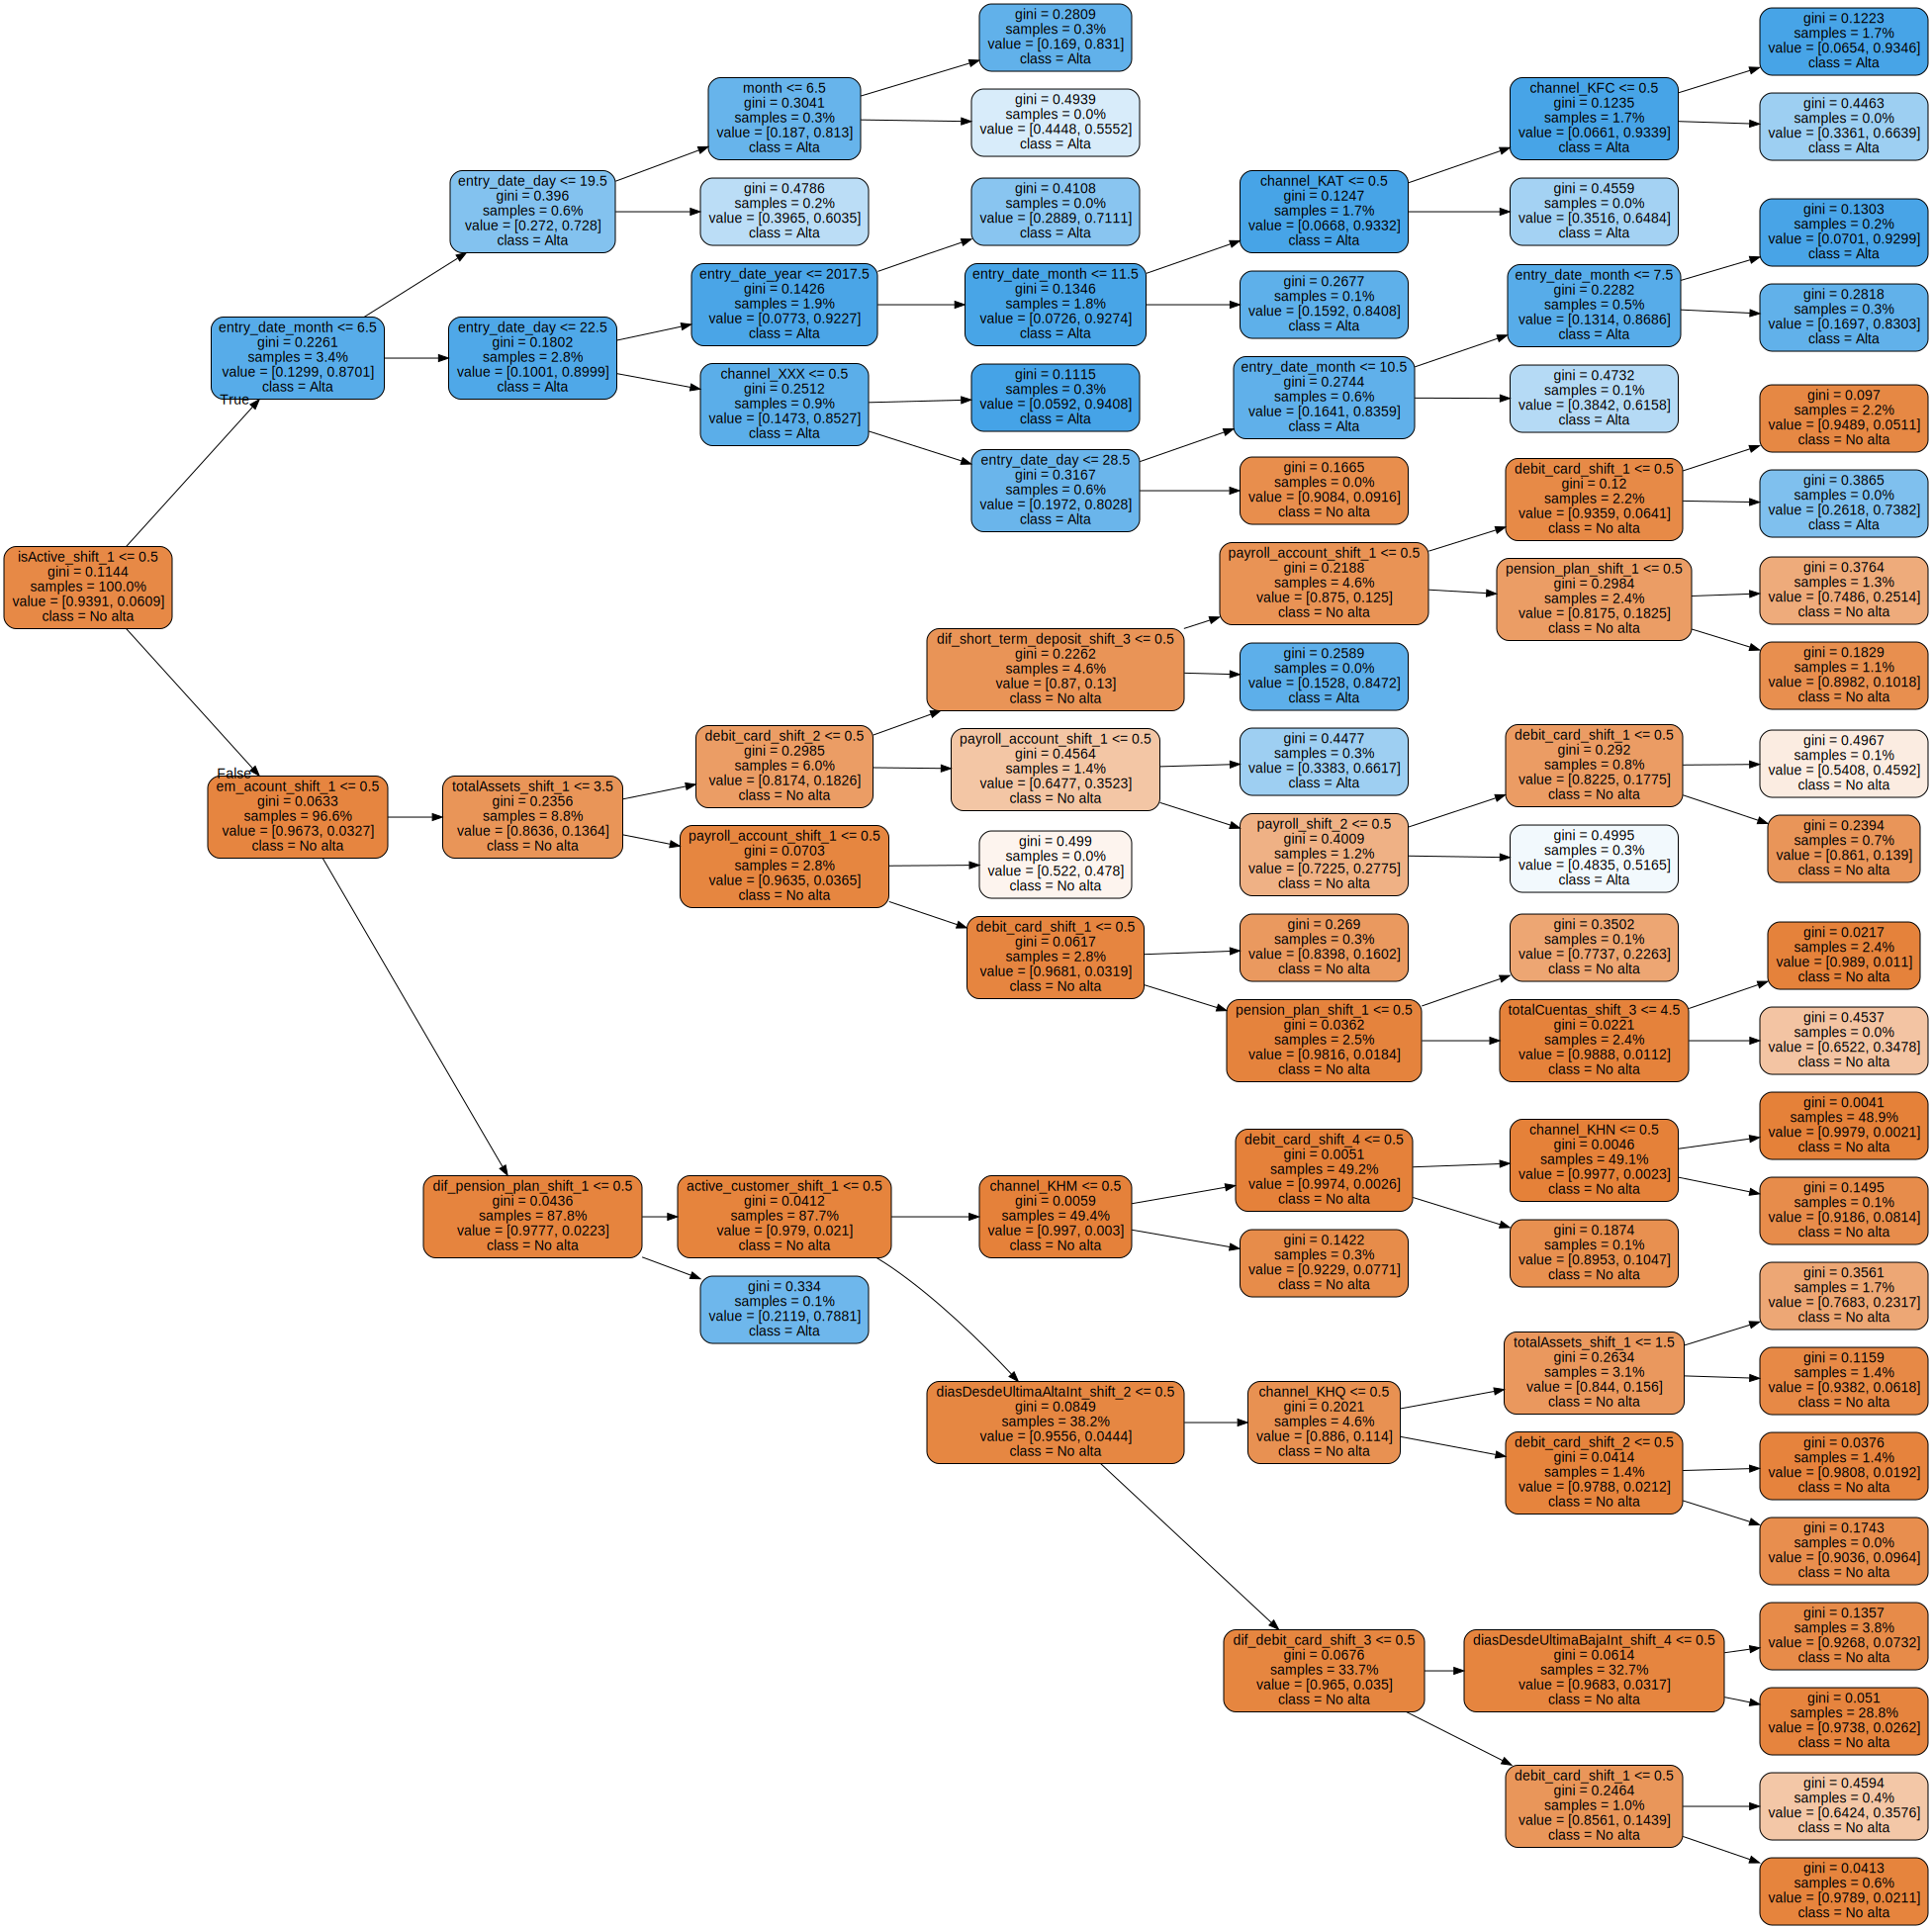

In [9]:
dot_data = export_graphviz(
                        decision_tree = dt,
                        # out_file=None,
                        # max_depth=None,
                        feature_names=X_test.columns,
                        class_names=['No alta', 'Alta'],
                        # label='all',
                        filled=True,
                        # leaves_parallel=False,
                        impurity=True,
                        # node_ids=False,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        # special_characters=False,
                        precision=4,
                        )

graph = graphviz.Source(dot_data)
graph

In [185]:
# Lo pasamos a pdf
graph.render(filename='arbol_EasyMoney')

'arbol_EasyMoney.pdf'

# Vemos con Test

In [10]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=Y_test.index, columns=['altaPrediction'])

In [11]:
len(y_test_pred)

331588

In [12]:
score_test=dt.score(X_test, Y_test)

In [13]:
score_test

0.9700924038264352

In [14]:
results_df = Y_test.to_frame().join(y_test_pred)

In [15]:
results_df['Success']=(results_df['dif_cuentaSimple']==results_df['altaPrediction']).astype(int)

In [16]:
results_df[results_df['dif_cuentaSimple']!=0].sample(20)

,dif_cuentaSimple,altaPrediction,Success
5514287,1.00,0.00,0
5458701,1.00,0.00,0
5345427,1.00,0.00,0
5415331,1.00,0.00,0
5632334,1.00,0.00,0
5431046,1.00,0.00,0
5387537,1.00,0.00,0
5543526,1.00,0.00,0
5329423,1.00,0.00,0
5636919,1.00,1.00,1


Vemos los aciertos para las altas de algun producto de cuenta simple:

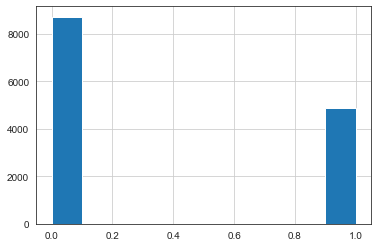

In [17]:
results_df[results_df['dif_cuentaSimple']==1]['Success'].hist()

Acertamos 4300 y fallamos 9290. 

In [18]:
results_df[results_df['dif_cuentaSimple']==1]['Success'].value_counts()

0    8728
1    4867
Name: Success, dtype: int64

Vemos los aciertos para las no altas de alguno de los prodcutos de cuenta simple:

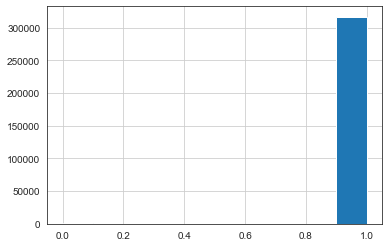

In [19]:
results_df[results_df['dif_cuentaSimple']==0]['Success'].hist()

Se aciertan 316815 y solo se escapan 1178 altas que no se han predecido como tal:

In [20]:
results_df[results_df['dif_cuentaSimple']==0]['Success'].value_counts()

1    316804
0      1189
Name: Success, dtype: int64

In [21]:
top_features = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)

In [22]:
top_features

isActive_shift_1                 0.78
em_acount_shift_1                0.04
dif_pension_plan_shift_1         0.03
totalAssets_shift_1              0.02
debit_card_shift_1               0.02
payroll_account_shift_1          0.02
debit_card_shift_2               0.02
active_customer_shift_1          0.01
payroll_shift_2                  0.01
diasDesdeUltimaAltaInt_shift_2   0.01
entry_date_day                   0.01
entry_date_month                 0.01
channel_KHQ                      0.01
pension_plan_shift_1             0.01
dif_short_term_deposit_shift_3   0.01
dif_debit_card_shift_3           0.00
diasDesdeUltimaBajaInt_shift_4   0.00
channel_XXX                      0.00
entry_date_year                  0.00
month                            0.00
channel_KHM                      0.00
debit_card_shift_4               0.00
channel_KHN                      0.00
channel_KAT                      0.00
channel_KFC                      0.00
totalCuentas_shift_3             0.00
dif_em_accou

Curva RoC y metrica AUC

Sacamos la probabilidad de alta calculada para los productos de cuenta simple:

In [23]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=Y_test.index, columns=['AltaScore'])
results_df = results_df.join(y_score)

In [24]:
results_df[results_df['dif_cuentaSimple']!=0].sample(20)

,dif_cuentaSimple,altaPrediction,Success,AltaScore
5632809,1.00,0.00,0,0.07
5628388,1.00,0.00,0,0.01
5548414,1.00,0.00,0,0.25
5310685,1.00,0.00,0,0.14
5611997,1.00,0.00,0,0.06
5636669,1.00,1.00,1,0.83
5521841,1.00,0.00,0,0.03
5627258,1.00,1.00,1,0.83
5635893,1.00,1.00,1,0.83
5352737,1.00,0.00,0,0.03


In [25]:
results_df['AltaScore'].value_counts(ascending=False).reset_index(name='Count')

,index,Count
0,0.00,158165
1,0.03,109614
2,0.07,9059
3,0.01,8975
4,0.05,7769
5,0.23,5727
6,0.25,5405
7,0.06,4548
8,0.10,3959
9,0.14,3129


Vemos que tenemos algunas hojas del arbol para solo 6 clientes. 

In [26]:
print(metrics.roc_auc_score(results_df['dif_cuentaSimple'], results_df['AltaScore']))

0.9037188889524375


In [27]:
fpr, tpr, _ = metrics.roc_curve(results_df['dif_cuentaSimple'], results_df['AltaScore'])

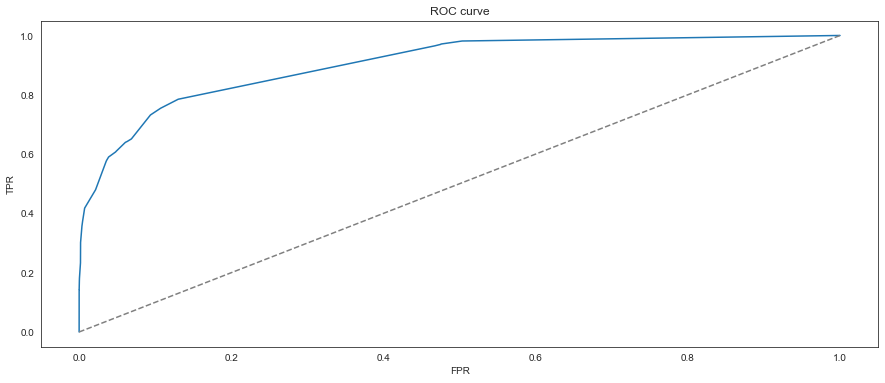

In [28]:
fig, ax = plt.subplots(figsize = (15, 6))
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

Vamos a sacar los clientes que hemos acertado realmente y con una probabilidad añta de compra:

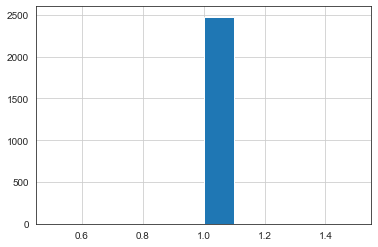

In [29]:
results_df[(results_df['dif_cuentaSimple']!=0) &
           (results_df['AltaScore']> 0.70) ]['Success'].hist()

In [29]:
results_df[(results_df['dif_cuentaSimple']!=0) &
           (results_df['AltaScore']> 0.50) ]['Success'].value_counts()

1    4867
Name: Success, dtype: int64

Vemos que tenemos unos 4300 clientes que es muy,muyy probable que nos contraten un producto de cuenta simple. Sobre ellos podriamos centrar una campaña de marketing ofreciendoles algun producto de estos.

Nos vamos a quedar con los clientes para los quedar el algoritmo ha dado una posibilidad mayor del 70% de que contraten un producto de cuenta simple:

In [31]:
results_df[results_df['AltaScore']> 0.65 ]

,dif_cuentaSimple,altaPrediction,Success,AltaScore
5305501,0.00,1.00,0,0.79
5305566,0.00,1.00,0,0.66
5305567,1.00,1.00,1,0.79
5305641,1.00,1.00,1,0.83
5305663,1.00,1.00,1,0.83
...,...,...,...,...
5636719,1.00,1.00,1,0.83
5636720,1.00,1.00,1,0.83
5636721,1.00,1.00,1,0.83
5636722,1.00,1.00,1,0.83


Nos quedamos solo con el campo de la probabilidad de dar un alta de cuenta simple:

In [32]:
results_df[results_df['AltaScore']> 0.65 ]['AltaScore'].to_frame()

,AltaScore
5305501,0.79
5305566,0.66
5305567,0.79
5305641,0.83
5305663,0.83
...,...
5636719,0.83
5636720,0.83
5636721,0.83
5636722,0.83


Se lo concatenamos al dataset original ya que en este es donde esta la informacion del pk_cid del cliente

In [33]:
full_df = pd.concat([full_df,results_df[results_df['AltaScore']> 0.65 ]['AltaScore'].to_frame()],axis=1)

In [34]:
full_df.rename(columns={'AltaScore':'AltaScoreCuentaSimple'},inplace=True)

Obviamente, se nos han generado muchisimos nulos en esta operacion. A estos les damos la probabilidad 0

In [35]:
full_df['AltaScoreCuentaSimple'].value_counts(dropna=False)

nan     5060232
0.83       1794
0.66       1114
0.79        481
0.74        119
0.93         76
0.94         65
0.71         64
0.84         20
0.85          3
0.66          1
0.83          1
Name: AltaScoreCuentaSimple, dtype: int64

In [36]:
full_df['AltaScoreCuentaSimple'].fillna(0, inplace=True)

In [40]:
full_df['AltaScoreCuentaSimple'].value_counts(dropna=False)

0.00    5060232
0.83       1794
0.66       1114
0.79        481
0.74        119
0.93         76
0.94         65
0.71         64
0.84         20
0.85          3
0.66          1
0.83          1
Name: AltaScoreCuentaSimple, dtype: int64

In [47]:
full_df[ (full_df['AltaScoreCuentaSimple'] > 0.65) ].groupby(['AltaScoreCuentaSimple']).size().sum()

3738

Generamos el fichero ".csv" con los pk_cid y las probabiliadades de alta que pasaremos a sistemas.

In [46]:
full_df[ (full_df['AltaScoreCuentaSimple']>= 0.65) ][['pk_cid','AltaScoreCuentaSimple']].to_csv(
    '../Datos-Easymoney/recomendacion_cuentaSimple.csv',index=False)

# Enternamos para ahorroInversion:

In [111]:
del X_train,Y_train, X_valida, Y_valida,X_test,Y_test
gc.collect()


85444

In [112]:
X_train = full_df[full_df["pk_partition"].isin(train_index)].drop(variables_borrar, axis=1)
Y_train = full_df[full_df["pk_partition"].isin(train_index)]['dif_ahorroInversion']

X_valida = full_df[full_df["pk_partition"].isin(valida_index)].drop(variables_borrar, axis=1)
Y_valida = full_df[full_df["pk_partition"].isin(valida_index)]['dif_ahorroInversion']

X_test = full_df[full_df["pk_partition"].isin(test_index)].drop(variables_borrar, axis = 1)
Y_test = full_df[full_df["pk_partition"].isin(test_index)]['dif_ahorroInversion']

In [113]:
dt.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [114]:
score_train=dt.score(X_train, Y_train)
score_test=dt.score(X_valida, Y_valida)
print('Resultados para: Train: {} - Test: {}'.format(score_train,score_test))


Resultados para: Train: 0.9894363059900456 - Test: 0.9918550218234281


Predecimos para Test:

In [115]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=Y_test.index, columns=['altaPrediction'])


In [116]:
score_test=dt.score(X_test, Y_test)

In [117]:
score_test

0.9914743597476386

In [118]:
results_df = Y_test.to_frame().join(y_test_pred)

In [119]:
results_df['Success']=(results_df['dif_ahorroInversion']==results_df['altaPrediction']).astype(int)

In [120]:
results_df[results_df['dif_ahorroInversion']!=0].sample(20)

,dif_ahorroInversion,altaPrediction,Success
5383768,1.00,1.00,1
5469464,1.00,1.00,1
5550318,1.00,0.00,0
5527824,1.00,0.00,0
5499909,1.00,0.00,0
5459387,1.00,1.00,1
5614360,1.00,0.00,0
5415863,1.00,0.00,0
5331344,1.00,0.00,0
5432207,1.00,1.00,1


Vemos los aciertos para las altas de algun producto de Ahorro/inversion:

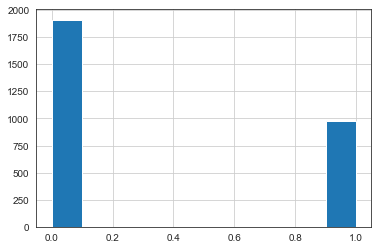

In [121]:
results_df[results_df['dif_ahorroInversion']==1]['Success'].hist()

Acertamos unos 1000 y fallamos unos 2000

In [122]:
results_df[results_df['dif_ahorroInversion']==1]['Success'].value_counts()

0    1911
1     974
Name: Success, dtype: int64

Vemos los aciertos para las no altas de alguno de los prodcutos de Ahorro/Inversion:

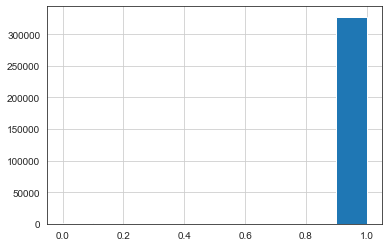

In [123]:
results_df[results_df['dif_ahorroInversion']==0]['Success'].hist()

Vemos que se aciertan 327787 No altas y solo hay unas 1000 altas de producto Ahorro/Inversion no predichas como tal

In [124]:
results_df[results_df['dif_ahorroInversion']==0]['Success'].value_counts()

1    327787
0       916
Name: Success, dtype: int64

In [125]:
top_features = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)


In [126]:
top_features

short_term_deposit_shift_1       0.38
pension_plan_shift_2             0.28
pension_plan_shift_1             0.16
payroll_account_shift_2          0.09
month                            0.03
diasDesdeUltimaBajaInt_shift_2   0.01
isNewClient_shift_1              0.01
channel_KHQ                      0.01
payroll_shift_3                  0.01
active_customer_shift_1          0.00
short_term_deposit_shift_2       0.00
channel_XXX                      0.00
debit_card_shift_1               0.00
payroll_shift_4                  0.00
dif_cuentaSimple_shift_1         0.00
payroll_account_shift_1          0.00
em_acount_shift_4                0.00
totalCuentas_shift_3             0.00
dif_pension_plan_shift_2         0.00
dif_short_term_deposit_shift_4   0.00
active_customer_shift_4          0.00
channel_KHM                      0.00
totalAhorro_shift_4              0.00
totalAssets_shift_1              0.00
dif_long_term_deposit_shift_1    0.00
year                             0.00
dif_ahorroIn

Curva RoC y metrica AUC

Calcualmos la probabilidad de que los clientes contraten algun producto de Ahorro/inversion:

In [127]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=Y_test.index, columns=['AltaScore'])
results_df = results_df.join(y_score)


In [168]:
#results_df[results_df['dif_ahorroInversion']!=0].sample(20)

In [128]:
print(metrics.roc_auc_score(results_df['dif_ahorroInversion'], results_df['AltaScore']))

0.9083283756006506


In [129]:
fpr, tpr, _ = metrics.roc_curve(results_df['dif_ahorroInversion'], results_df['AltaScore'])

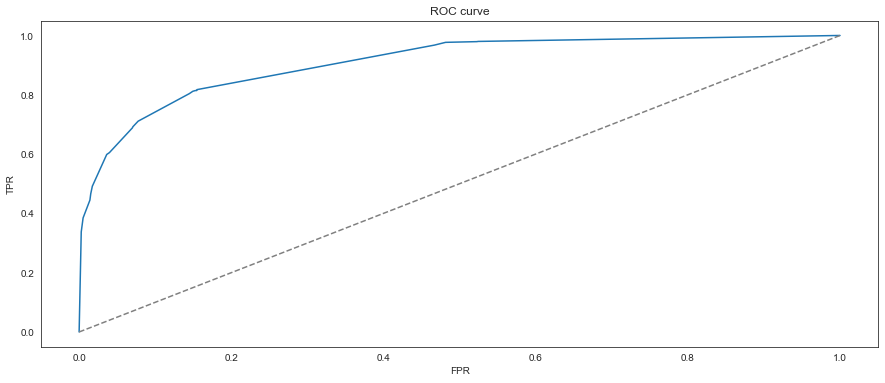

In [130]:
fig, ax = plt.subplots(figsize = (15, 6))
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

Calculamos los clientes que tienen una posibilidad alta de hacer una compra de algujn producto de ahorro / inversion:

In [131]:
results_df[(results_df['dif_ahorroInversion']!=0) &
           (results_df['AltaScore']> 0.60) ]

,dif_ahorroInversion,altaPrediction,Success,AltaScore
5305793,1.00,1.00,1,0.60
5306156,1.00,1.00,1,0.60
5306773,1.00,1.00,1,0.60
5306878,1.00,1.00,1,0.60
5307103,1.00,1.00,1,0.60
...,...,...,...,...
5628414,1.00,1.00,1,0.60
5628630,1.00,1.00,1,0.60
5629217,1.00,1.00,1,0.60
5629602,1.00,1.00,1,0.60


In [132]:
results_df[(results_df['dif_ahorroInversion']!=0) &
           (results_df['AltaScore']>= 0.60) ]['Success'].value_counts()


1    974
Name: Success, dtype: int64

Tenemos unos 100 clientes con una posibilidad alta de hacer una compra de algun producto de Ahorro/inversion. 

Nos quedamos con los clientes a los que el algoritmo da una probabilidad de compra mayor del 60%

In [133]:
results_df[(results_df['AltaScore']>= 0.60) ]

,dif_ahorroInversion,altaPrediction,Success,AltaScore
5305793,1.00,1.00,1,0.60
5305970,0.00,1.00,0,0.60
5306156,1.00,1.00,1,0.60
5306432,0.00,1.00,0,0.60
5306628,0.00,1.00,0,0.60
...,...,...,...,...
5629602,1.00,1.00,1,0.60
5629669,1.00,1.00,1,0.60
5630696,0.00,1.00,0,0.60
5630865,0.00,1.00,0,0.60


Se lo concatenamos al dataset original ya que en este es donde esta la informacion del pk_cid del cliente

In [141]:
full_df = pd.concat([full_df,results_df[results_df['AltaScore']> 0.60 ]['AltaScore'].to_frame()],axis=1)
full_df.rename(columns={'AltaScore':'AltaScoreAhorroInversion'},inplace=True)


Obviamente, se nos han generado muchisimos nulos en esta operacion. A estos les damos la probabilidad 0

In [142]:
full_df['AltaScoreAhorroInversion'].value_counts(dropna=False)

nan     5062080
0.60       1881
0.70          9
Name: AltaScoreAhorroInversion, dtype: int64

In [143]:
full_df['AltaScoreAhorroInversion'].fillna(0, inplace=True)

Generamos el fichero ".csv" con los pk_cid y las probabiliadades de alta que pasaremos a sistemas.

In [147]:
full_df[ (full_df['AltaScoreAhorroInversion']>= 0.60) ][['pk_cid','AltaScoreAhorroInversion']].to_csv(
    '../Datos-Easymoney/recomendacion_ahorroInversion.csv',index=False)

# Enternamos para financiacion:

In [82]:
del X_train,Y_train, X_valida, Y_valida,X_test,Y_test
gc.collect()


42275

In [83]:
X_train = full_df[full_df["pk_partition"].isin(train_index)].drop(variables_borrar, axis=1)
Y_train = full_df[full_df["pk_partition"].isin(train_index)]['dif_financiacion']

X_valida = full_df[full_df["pk_partition"].isin(valida_index)].drop(variables_borrar, axis=1)
Y_valida = full_df[full_df["pk_partition"].isin(valida_index)]['dif_financiacion']

X_test = full_df[full_df["pk_partition"].isin(test_index)].drop(variables_borrar, axis = 1)
Y_test = full_df[full_df["pk_partition"].isin(test_index)]['dif_financiacion']


In [84]:
dt.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [85]:
score_train=dt.score(X_train, Y_train)
score_test=dt.score(X_valida, Y_valida)
print('Resultados para: Train: {} - Test: {}'.format(score_train,score_test))


Resultados para: Train: 0.9976464202147419 - Test: 0.9978511380445965


In [86]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=Y_test.index, columns=['altaPrediction'])


In [87]:
score_test=dt.score(X_test, Y_test)

In [88]:
score_test

0.9977110148738796

In [89]:
results_df = Y_test.to_frame().join(y_test_pred)


In [90]:
results_df['Success']=(results_df['dif_financiacion']==results_df['altaPrediction']).astype(int)


In [91]:
results_df[results_df['dif_financiacion']!=0].sample(20)

,dif_financiacion,altaPrediction,Success
5457857,1.00,0.00,0
5367981,1.00,0.00,0
5310734,1.00,0.00,0
5469477,1.00,0.00,0
5589104,1.00,0.00,0
5463039,1.00,0.00,0
5340003,1.00,0.00,0
5427424,1.00,0.00,0
5490132,1.00,0.00,0
5305680,1.00,0.00,0


Vemos los aciertos para las altas de algun producto de Financiacion:

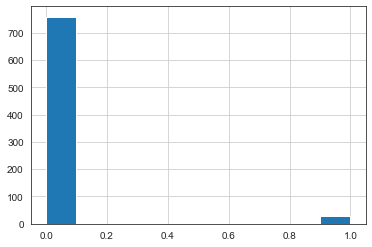

In [92]:
results_df[results_df['dif_financiacion']==1]['Success'].hist()

Solo acertamos 30 de 760. ..... 

In [93]:
results_df[results_df['dif_financiacion']==1]['Success'].value_counts()

0    758
1     30
Name: Success, dtype: int64

Vemos los aciertos para las NO altas de algun producto de Financiacion:

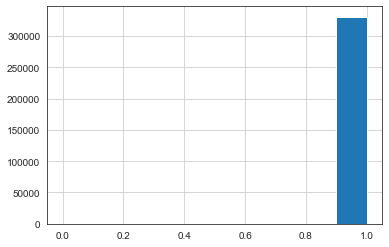

In [94]:
results_df[results_df['dif_financiacion']==0]['Success'].hist()

Se aciertan 330752 No altas y solo hay 50 altas no predichas como tal.

In [95]:
results_df[results_df['dif_financiacion']==0]['Success'].value_counts()

1    330799
0         1
Name: Success, dtype: int64

In [96]:
top_features = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)


In [97]:
top_features

totalFinanciacion_shift_1     0.50
loans_shift_1                 0.25
credit_card_shift_3           0.12
credit_card_shift_4           0.07
credit_card_shift_2           0.03
totalAssets_shift_1           0.02
totalAssets_shift_4           0.00
totalAssets_shift_3           0.00
dif_mortgage_shift_1          0.00
credit_card_shift_1           0.00
payroll_account_shift_1       0.00
em_account_p_shift_1          0.00
totalCuentas_shift_2          0.00
totalAssets_shift_2           0.00
dif_em_acount_shift_1         0.00
securities_shift_3            0.00
dif_financiacion_shift_1      0.00
dif_ahorroInversion_shift_3   0.00
dif_ahorroInversion_shift_2   0.00
long_term_deposit_shift_4     0.00
dif_ahorroInversion_shift_1   0.00
dif_cuentaSimple_shift_4      0.00
short_term_deposit_shift_1    0.00
dif_cuentaSimple_shift_3      0.00
dif_cuentaSimple_shift_2      0.00
dif_cuentaSimple_shift_1      0.00
short_term_deposit_shift_2    0.00
dif_em_account_p_shift_4      0.00
dif_em_account_p_shi

Curva ROC y metrica AUC

Sacamos la probabilidad de lata de alguno de los productos de financiacion:

In [98]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=Y_test.index, columns=['AltaScore'])
results_df = results_df.join(y_score)


In [99]:
results_df[results_df['dif_financiacion']!=0].sample(20)

,dif_financiacion,altaPrediction,Success,AltaScore
5383322,1.00,0.00,0,0.31
5305445,1.00,0.00,0,0.12
5310850,1.00,0.00,0,0.01
5458168,1.00,0.00,0,0.00
5572304,1.00,0.00,0,0.01
5305693,1.00,0.00,0,0.12
5500135,1.00,0.00,0,0.01
5457734,1.00,0.00,0,0.31
5316242,1.00,0.00,0,0.12
5622089,1.00,0.00,0,0.00


In [100]:
print(metrics.roc_auc_score(results_df['dif_financiacion'], results_df['AltaScore']))

0.9038172170679909


In [101]:
fpr, tpr, _ = metrics.roc_curve(results_df['dif_financiacion'], results_df['AltaScore'])

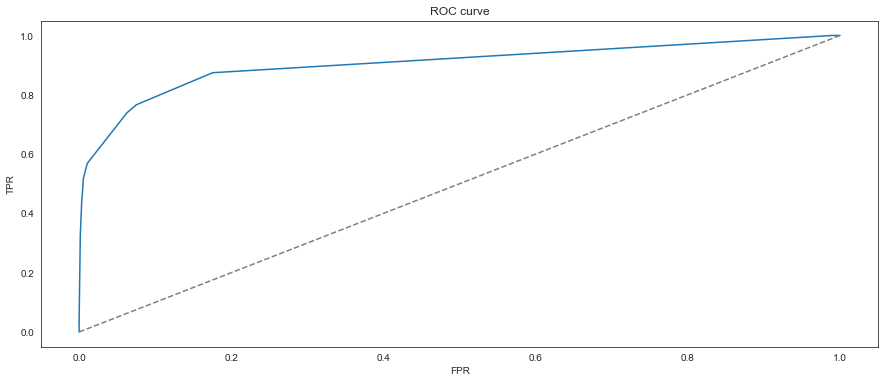

In [102]:
fig, ax = plt.subplots(figsize = (15, 6))
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

Vamos a ver los clientes que dan alta y que el modelo ha predicho como de lata posibilidad (Mayor del 60%) de hacer uan comopra de un producto de financiaicoin:

In [103]:
results_df[(results_df['dif_financiacion']!=0) &
           (results_df['AltaScore']> 0.60) ].sample(20)


,dif_financiacion,altaPrediction,Success,AltaScore
5545656,1.00,1.00,1,0.98
5390989,1.00,1.00,1,0.98
5422342,1.00,1.00,1,0.98
5383528,1.00,1.00,1,0.98
5355720,1.00,1.00,1,0.98
5355500,1.00,1.00,1,0.98
5324548,1.00,1.00,1,0.98
5518536,1.00,1.00,1,0.98
5459390,1.00,1.00,1,0.98
5464426,1.00,1.00,1,0.98


In [104]:
results_df[(results_df['dif_financiacion']!=0) &
           (results_df['AltaScore']> 0.70) ]['Success'].value_counts()

1    30
Name: Success, dtype: int64

Tenemos unos 30 clientes detectados como de alta probabilidad de contratacion de un  producto de financiacion.

Nos vamos a quedar con los clienets para los cuales el algoritmo ha predicho una posibilidad de alta mayor del 70%.

In [105]:
results_df[(results_df['AltaScore']> 0.70) ]

,dif_financiacion,altaPrediction,Success,AltaScore
5311862,1.00,1.00,1,0.98
5323524,1.00,1.00,1,0.98
5324548,1.00,1.00,1,0.98
5341355,1.00,1.00,1,0.98
5355500,1.00,1.00,1,0.98
5355720,1.00,1.00,1,0.98
5357560,1.00,1.00,1,0.98
5357790,1.00,1.00,1,0.98
5365442,1.00,1.00,1,0.98
5366752,1.00,1.00,1,0.98


In [106]:
results_df[results_df['AltaScore']> 0.70 ]['AltaScore'].to_frame()

,AltaScore
5311862,0.98
5323524,0.98
5324548,0.98
5341355,0.98
5355500,0.98
5355720,0.98
5357560,0.98
5357790,0.98
5365442,0.98
5366752,0.98


Se lo concatenamos al dataset original ya que en este es donde esta la informacion del pk_cid del cliente


In [107]:
full_df = pd.concat([full_df,results_df[results_df['AltaScore']> 0.70 ]['AltaScore'].to_frame()],axis=1)
full_df.rename(columns={'AltaScore':'AltaScoreFinanciacion'},inplace=True)


Obviamente, se nos han generado muchisimos nulos en esta operacion. A estos les damos la probabilidad 0

In [108]:
full_df['AltaScoreFinanciacion'].value_counts(dropna=False)

nan     5063940
0.98         30
Name: AltaScoreFinanciacion, dtype: int64

In [109]:
full_df['AltaScoreFinanciacion'].fillna(0, inplace=True)

Generamos el fichero ".csv" con los pk_cid y las probabiliadades de alta que pasaremos a sistemas.

In [110]:
full_df[ (full_df['AltaScoreFinanciacion']>= 0.70) ][['pk_cid','AltaScoreFinanciacion']].to_csv(
    '../Datos-Easymoney/recomendacion_financiacion.csv',index=False)
